# Introduction

TARGRES, or <ins>T</ins>ree-based <ins>Arg</ins>umetation <ins>Res</ins>olution, is built as a bias-reducing approach for identifying the most robust answers for complex - but deterministic - debates.  

In the present notebook lays the data analysis and intelligence pipeline defined to use Kialo's data in TARGRES' main study.

In [4]:
%load_ext autoreload
%autoreload 2

import pickle
import requests
import numpy as np
import pandas as pd
import pyarrow as pa
from pprint import pprint
from tqdm.notebook import tqdm

tqdm.pandas()

## Data Scraping
Below are the methods used to obtain a custom tree-like dataset from the Kialo API, thoroughly documented under the `scraping` and `tree_mapping` local modules. Working as of Sep. 13th, 2020.

In [ ]:
from tree_mapping import map_as_tree
from scraping import get_discussions, scrape_into

discussions = get_discussions()
scrape_into(discussions)
map_as_tree(discussions)

In [ ]:
with open('raw_discussions.pkl', 'wb') as file:
    pickle.dump(discussions, file)

In [ ]:
with open('raw_discussions.pkl', 'rb') as file:
    discussions = pickle.load(file)

## Preprocessing
A standard preprocessing/feature engineering sequence over the above data, better seen by inspecting the methods within the `preprocessing` module.

In [ ]:
from preprocessing import discussions_to_df, discussions_to_claim_df
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 70

discdf = discussions_to_df(discussions)
claimdf = discussions_to_claim_df(discdf)

In [ ]:
claimdf['creation_delta'] = claimdf.claim_created - claimdf.disc_created
claimdf.creation_delta.sample(5)

48528      172320867
55747    30435906604
3309     25420859939
28321    36312654503
46988     4341230701
Name: creation_delta, dtype: int64

In [ ]:
from preprocessing import clean_text

clean_stategy = lambda t: clean_text(t, punctuation=False)
claimdf['clean_text'] = claimdf.claim_text.apply(clean_stategy)
claimdf['clean_disc_title'] = claimdf.disc_title.apply(clean_stategy)

In [ ]:
claimdf.to_pickle('clean_claims_df.pkl')

# Data Visualization
Graphs rendered to composo the logic of the study are condensed in this section.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [26]:
discussion_ids = claimdf.disc_id.unique()
disccols = [col for col in claimdf if col.startswith('disc_')]
disc_viz = pd.concat([
                      claimdf[claimdf.disc_id == ID].iloc[0] for ID in discussion_ids
                      ], axis=1).T[disccols]
disc_viz.sample(3)

,disc_id,disc_title,disc_created,disc_tags,disc_thesis_robustness,disc_avg_veracity,disc_argument_count,disc_view_count,disc_vote_count,disc_contribution_count,disc_participant_count
51461,10214,Should sensitive social and political topics b...,1520791698594,"[Politics, USA, Society, Law, Education, School]",22.2593,6.8,196,7802,529,1406,277
79580,14060,Should More Congressional Voting Be By Secret ...,1524940669090,"[Government, Politics, Elections]",0.812275,0.2,20,434,5,109,11
74660,13386,Should the United States be the global police?,1523801627040,"[Security, Government, USA, Politics, Police]",0.0112888,8.8,247,14013,971,1829,281


In [46]:
from data_filters import is_thesis

thesis_ratings = claimdf[claimdf.claim_id.apply(is_thesis)][['disc_id', 'claim_avg_impact']]
thesis_ratings = dict(zip(thesis_ratings.disc_id.values, thesis_ratings.claim_avg_impact.values))
disc_viz['thesis_ratings'] = disc_viz.disc_id.apply(thesis_ratings.get)

vals = [disc_viz.thesis_ratings.values, disc_viz.disc_thesis_robustness.values]
disc_viz['norm_thesis_ratings'] = (vals[0] - np.min(vals[0])) / np.ptp(vals[0])
disc_viz['norm_thesis_robustness'] = (vals[1] - np.min(vals[1])) / np.ptp(vals[1])

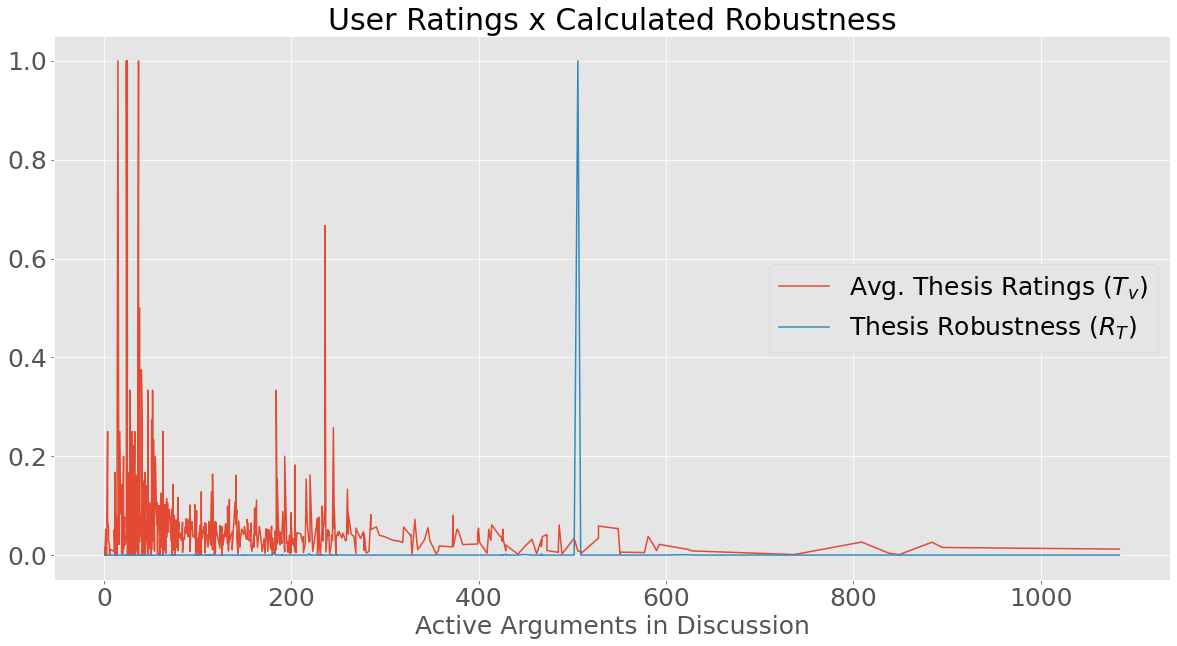

In [127]:
disc_viz['active_arguments_count'] = [claimdf[claimdf.disc_id == disc_viz.iloc[i].disc_id].shape[0] for i in range(disc_viz.shape[0])]

fig, ax = plt.subplots(figsize=(20, 10))

disc_viz = disc_viz.sort_values(by='active_arguments_count')
arg_count = disc_viz.active_arguments_count

ax.plot(arg_count, disc_viz.norm_thesis_ratings, label='Avg. Thesis Ratings ($T_v$)')
ax.plot(arg_count, disc_viz.norm_thesis_robustness, label='Thesis Robustness ($R_T$)')

ax.legend(loc='center right', fontsize=25)
plt.xlabel('Active Arguments in Discussion', fontsize=25)
ax.set_title('User Ratings x Calculated Robustness', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)

plt.show()

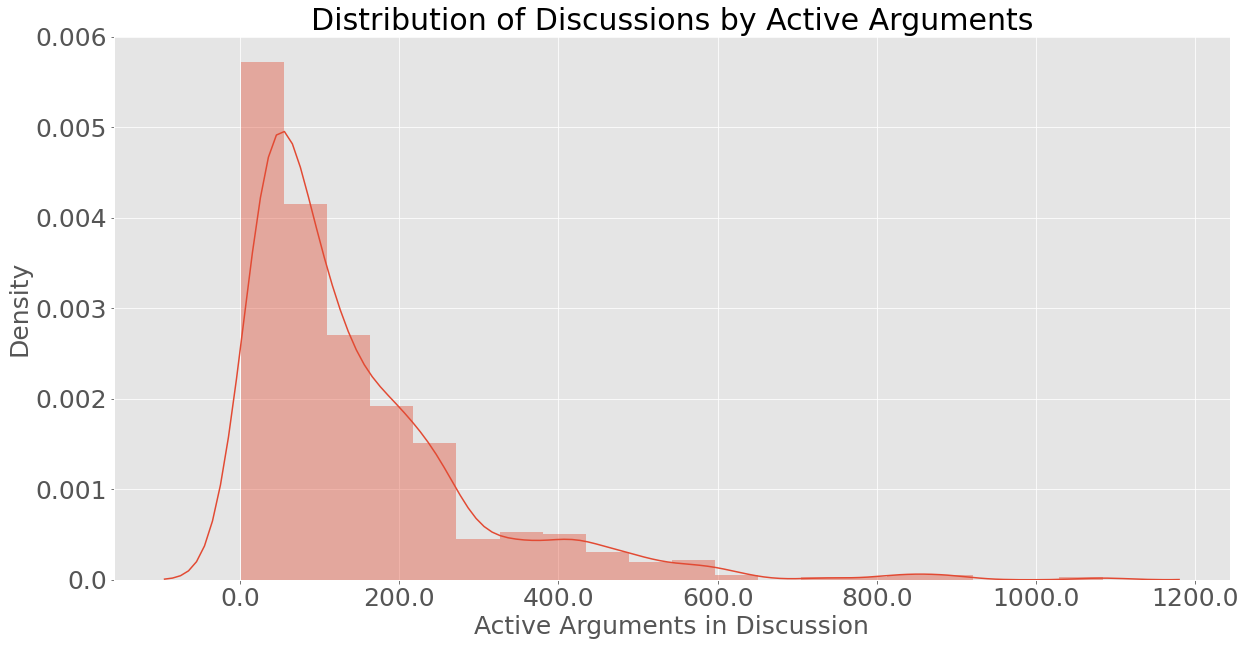

In [126]:
fig, ax = plt.subplots(figsize=(20, 10))

aplot = sns.distplot(disc_viz.active_arguments_count, hist=True, kde=True, bins=20)
aplot.set_yticklabels(aplot.get_yticks(), size = 25)
aplot.set_xticklabels(aplot.get_xticks(), size = 25)

plt.ylabel('Density', fontsize=25)
plt.xlabel('Active Arguments in Discussion', fontsize=25)
ax.set_title('Distribution of Discussions by Active Arguments', fontsize=30)


plt.show()

In [86]:
disc_viz.disc_argument_count.skew()

3.9836411239368776

# Intelligence Architecture 

In [5]:
claimdf = pd.read_pickle('clean_claims_df.pkl')

In [6]:
claimdf.shape

(96755, 25)

In [11]:
from data_filters import is_thesis

theses_idx = claimdf.claim_id.apply(is_thesis)
claims_idx = ~theses_idx

## BERT Embeddings

Claims and theses' text needs to be numerically represented in order to be used as a training feature. For this purpose, BERT's pretrained model of type `bert-base-uncased` will be used below.  

Since both claims and theses are inside `claimdf`, all will have numerical representations that take advantage of BERT's considerable grasp of sentence context.

In [24]:
from bert_embedding import generate_embeddings

results = generate_embeddings(claimdf.clean_text.values)

Finished BERT embeddings after 4566.83s


In [26]:
with open('claim_embeddings.pkl', 'wb') as file:
    pickle.dump(results, file)

In [17]:
with open('claim_embeddings.pkl', 'rb') as file:
    results = pickle.load(file)

In [18]:
from bert_embedding import bert_model

results.shape, bert_model.config.hidden_size

(torch.Size([96755, 768]), 768)

In [138]:
embdf = pd.DataFrame(results.numpy(), columns=[f'EMB_{i}' for i in range(bert_model.config.hidden_size)])
embdf.index = claimdf.index

In [280]:
theses = claimdf[theses_idx].join(embdf)
claims = claimdf[claims_idx].join(embdf)

theses.shape, claims.shape

((662, 793), (96093, 793))

# PCA: Thesis embeddings

Each discussion has its own thesis, and along with all the common arguments, each thesis was also embedded by BERT above. This may also give context to the model on the context by arguments under one same discussion - but joining the full embeddings would mean adding 768 new columns, for which reason a PCA will be performed in those before joining.

In [281]:
from sklearn.decomposition import PCA
N_COMPONENTS = 20
pca = PCA(n_components=N_COMPONENTS)
pca.fit(theses[embdf.columns].values.T)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [282]:
theses[embdf.columns].shape, pca.components_.shape

((662, 768), (20, 662))

In [283]:
pcadf = pd.DataFrame(pca.components_.T, columns=[f'PCA_{i}' for i in range(N_COMPONENTS)])
pcadf.index = theses.index

theses = theses.join(pcadf)
theses[['disc_id', 'claim_text'] + list(pcadf.columns)].sample(5)

,disc_id,claim_text,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
77801,22512,Having police officers in schools is a good idea.,0.046475,0.042887,-0.004435,0.059979,-0.053427,0.000260,0.037420,0.050025,0.000209,-0.124005,0.000028,0.004779,-0.000004,0.000118,-3.411293e-07,-1.087254e-08,2.493068e-02,-1.181179e-03,-2.960865e-02,3.137870e-02
6832,14491,Cultural appropriation is wrong.,0.043975,0.002614,-0.048215,0.007861,0.058993,-0.001284,-0.044927,0.026770,0.008152,-0.005260,-0.000005,-0.000209,-0.000015,-0.000019,5.703608e-07,1.735661e-08,-5.305408e-16,-2.866486e-16,-7.768447e-15,-7.758247e-15
55515,18393,Darwinian evolution is philosophy not science.,0.043975,0.002614,-0.048215,0.007861,0.058993,-0.001284,-0.044927,0.026770,0.008152,-0.005260,-0.000005,-0.000209,-0.000015,-0.000019,5.703608e-07,1.735661e-08,-5.305408e-16,-2.866486e-16,-7.768447e-15,-7.758247e-15
62080,9812,Empathy should be taught in school.,0.038534,-0.036887,0.004629,-0.023930,-0.025555,-0.018617,0.012384,-0.013855,0.149730,-0.000686,0.001357,-0.000066,0.000178,0.000191,1.116494e-04,1.474691e-05,-3.696231e-02,-1.303250e-03,-1.088604e-02,1.860205e-02
27578,5601,Donald Trump should be impeached and removed f...,0.041706,-0.020126,-0.034451,-0.055458,-0.034607,0.011282,0.014486,-0.003866,-0.023559,0.000786,0.000046,0.000026,0.000307,-0.000049,-2.752787e-05,-4.058510e-06,1.069962e-02,3.772566e-04,3.151222e-03,-5.384803e-03


In [284]:
claims = claims.merge(theses[['disc_id'] + list(pcadf.columns)], left_on='disc_id', right_on='disc_id')
display(claims.sample(5))
claims.shape, theses.shape

,claim_id,claim_created,claim_text,claim_level,claim_avg_impact,claim_pros,claim_cons,claim_robustness,claim_parent_id,claim_relation,claim_weight,disc_id,disc_title,disc_created,disc_tags,disc_thesis_robustness,disc_avg_veracity,disc_argument_count,disc_view_count,disc_vote_count,disc_contribution_count,disc_participant_count,creation_delta,clean_text,clean_disc_title,EMB_0,EMB_1,EMB_2,EMB_3,EMB_4,EMB_5,EMB_6,EMB_7,EMB_8,EMB_9,EMB_10,EMB_11,EMB_12,EMB_13,EMB_14,...,EMB_748,EMB_749,EMB_750,EMB_751,EMB_752,EMB_753,EMB_754,EMB_755,EMB_756,EMB_757,EMB_758,EMB_759,EMB_760,EMB_761,EMB_762,EMB_763,EMB_764,EMB_765,EMB_766,EMB_767,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
35527,14956.978,1593221362728,"Without knowledge of religious differences, di...",3,0.000000,[],[],1.666667,14956.976,1.0,1.666667,14956,Should religious education be compulsory in pu...,1526647533047,"[Ethics, Education, School, Children, Religion]",0.398972,7.0,284,12789,931,1483,327,66573829681,"without knowledge religious differences, discr...",religious education compulsory public schools?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.048092,0.076916,0.069271,-0.048349,0.005607,0.007115,-0.070542,-0.085332,-0.003776,-0.041394,0.000013,-0.053773,0.000006,0.035971,2.003976e-04,2.287024e-05,-4.552838e-03,-2.065288e-02,-1.592920e-02,-1.214067e-02
81759,2853.815,1521036658011,The US is the only country ever to drop nuclea...,4,0.000394,[],[],2.250394,2853.549,-1.0,2.250394,2853,Should the US stop trying to force North Korea...,1505476459587,"[NorthKorea, USA, Politics, NuclearWeapons]",0.456124,5.2,425,14016,1015,2587,294,15560198424,"us country ever drop nuclear weapons city, twi...",us stop trying force north korea abandon nucle...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.041706,-0.020126,-0.034451,-0.055458,-0.034607,0.011282,0.014486,-0.003866,-0.023559,0.000786,0.000046,0.000026,0.000307,-0.000049,-2.752787e-05,-4.058510e-06,1.069962e-02,3.772566e-04,3.151222e-03,-5.384803e-03
86835,17066.51,1532556047095,Being a politician can be stressful enough giv...,2,0.003226,[],[],4.003226,17066.5,1.0,4.003226,17066,Politicians' Second Jobs: Should They be Allow...,1532270550999,"[Politics, Business, Ethics, Government, Jobs,...",0.036839,0.4,154,1600,62,430,35,285496096,politician stressful enough given many respons...,politicians' second jobs: allowed keep them?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.038320,-0.033812,0.003958,-0.012996,-0.004161,0.001503,-0.003848,0.012232,-0.190024,0.001491,-0.006712,0.000095,-0.008788,-0.000287,-3.426028e-04,-6.819161e-05,-3.049391e-01,-1.075181e-02,-8.980982e-02,1.534669e-01
26825,16068.643,1552450648847,Some people participate in [naturist activitie...,3,0.000099,[],[],1.666766,16068.49,1.0,1.666766,16068,Should public nudity be legal?,1529093765821,"[Society, Culture, Gender, Law]",61.075638,46.0,649,230669,6059,10271,1220,23356883026,people participate naturist activities](https:...,public nudity legal?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.043975,0.002614,-0.048215,0.007861,0.058993,-0.001284,-0.044927,0.026770,0.008152,-0.005260,-0.000005,-0.000209,-0.000015,-0.000019,5.703608e-07,1.735661e-08,-5.305408e-16,-2.866486e-16,-7.768447e-15,-7.758247e-15
27116,2214.1960,1507625625656,It's unlikely that refugees would stay in thei...,4,0.000120,[],"[2214.1981, 2214.2607, 2214.2610]",0.158232,2214.1478,1.0,3.750120,2214,Should high-income countries take in refugees?,1498063254204,"[Refugees, Ethics, Politics, Immigration, Migr...",1.044634,24.0,1886,79273,20068,17622,1192,9562371452,unlikely refugees would stay host country give...,high-income countries take refugees?,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.038534,-0.036887,0.004629,-0.023930,-0.025555,-0.018617,0.012384,-0.013

((96093, 813), (662, 813))

## Regression over Embedded data
The below blocks will assess the logic used for running regression on the claim embeddings (plus appropriate metadata) to predict the weight of claims on their theses. The average weight, defined in the paper like:

$$
w_x = \frac{\displaystyle \sum_{i=1}^{s}{r_i}}{r_t*r} + \frac{l}{l_x}
$$

$w_x$ was calculated in the `tree_mapping` module's `traverse_robustness()` method, and is stored in claims as `avg_impact`.

In [287]:
features = [
            'claim_created',
            'creation_delta',
            'claim_level',
            'claim_relation'
            ] + list(embdf.columns) + list(pcadf.columns)
label = ['claim_avg_impact']

In [288]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.33
RANDOM_STATE = 42

X = claims[features]
y = claims[label]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [289]:
lgb_params = {
    'task': 'train',
    'learning_rate': 0.006,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    "max_depth": 7,
    "num_leaves": 100,
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [290]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(**lgb_params)

In [291]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        early_stopping_rounds=1000)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[1]	valid_0's auc: 0.61688	valid_0's rmse: 0.00296699	valid_0's l2: 8.80304e-06
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's auc: 0.62691	valid_0's rmse: 0.0029626	valid_0's l2: 8.77702e-06
[3]	valid_0's auc: 0.627105	valid_0's rmse: 0.00295782	valid_0's l2: 8.74872e-06
[4]	valid_0's auc: 0.625791	valid_0's rmse: 0.00295287	valid_0's l2: 8.71945e-06
[5]	valid_0's auc: 0.627741	valid_0's rmse: 0.00294801	valid_0's l2: 8.69075e-06
[6]	valid_0's auc: 0.626552	valid_0's rmse: 0.00294324	valid_0's l2: 8.66267e-06
[7]	valid_0's auc: 0.625973	valid_0's rmse: 0.0029385	valid_0's l2: 8.63478e-06
[8]	valid_0's auc: 0.625425	valid_0's rmse: 0.00293383	valid_0's l2: 8.60733e-06
[9]	valid_0's auc: 0.625401	valid_0's rmse: 0.00292925	valid_0's l2: 8.58049e-06
[10]	valid_0's auc: 0.608471	valid_0's rmse: 0.00292706	valid_0's l2: 8.5677e-06
[11]	valid_0's auc: 0.609	valid_0's rmse: 0.00292272	valid_0's l2: 8.54229e-06
[12]	valid_0's auc: 0.609291	valid_0's rmse: 0.0029

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.006, max_bin=512,
              max_depth=7, metric=['l2', 'auc'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=100000, num_leaves=100,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train')

In [292]:
gbm.score(X_test, y_test)

0.01604332534223596

In [ ]:
{
 5: 0.2632792685672478,
 10: 0.26212031096501387,
 15: 0.01599031326232425,
 20: 0.01597849720533895,
 25: 0.01603952402727804
}

In [296]:
import eli5
eli5.format_as_dataframe(eli5.explain_weights_lightgbm(gbm))

,feature,weight
0,claim_level,0.690656
1,creation_delta,0.132719
2,claim_created,0.069969
3,PCA_5,0.028853
4,PCA_3,0.016168
5,EMB_127,0.015307
6,EMB_296,0.009032
7,PCA_14,0.005758
8,claim_relation,0.005591
9,PCA_13,0.003938


In [297]:
gbm.booster_.save_model('gbm_regressor.txt')